In [3]:
from matplotlib import pyplot as plt 
%matplotlib inline
# ---------------------- Import the package ---------------------------
from delayed_economic_deicision import DelayedEconomicDecision_AlternateOutput 
from psychrnn.backend.models.basic import Basic
import numpy as np

In [4]:
# ---------------------- Set up a basic model ---------------------------
dd = DelayedEconomicDecision_AlternateOutput(dt = 10, tau = 100, T = 4000, N_batch = 64,target_delay_duration=500,wait_duration=500,outputMode='order')
network_params = dd.get_task_params() # get the params passed in and defined in pd 
network_params['name'] = 'model' # name the model uniquely if running mult models inunison
network_params['N_rec'] = 50 # set the number of recurrent units in the model
network_params['rec_noise'] = 0.1 # Noise into each recurrent unit. Default: 0.0
#model.destruct()
model = Basic(network_params) # instantiate a basic vanilla RNN


In [5]:
# ---------------------- Train a basic model --------------------------- 
train_params = {}
train_params['training_iters']=300000
losses, initialTime, trainTime = model.train(dd,train_params) # train model to perform pd task
# ---------------------- Test the trained model --------------------------- 
x,target_output,mask, trial_params = dd.get_trial_batch() # get pd task inputs and outputs
model_output, model_state = model.test(x) # run the model on input x

Iter 640, Minibatch Loss= 0.054226
Iter 1280, Minibatch Loss= 0.046115
Iter 1920, Minibatch Loss= 0.046496
Iter 2560, Minibatch Loss= 0.043470
Iter 3200, Minibatch Loss= 0.043827
Iter 3840, Minibatch Loss= 0.044210
Iter 4480, Minibatch Loss= 0.044287
Iter 5120, Minibatch Loss= 0.043641
Iter 5760, Minibatch Loss= 0.042204
Iter 6400, Minibatch Loss= 0.042917
Iter 7040, Minibatch Loss= 0.042623
Iter 7680, Minibatch Loss= 0.042230
Iter 8320, Minibatch Loss= 0.041839
Iter 8960, Minibatch Loss= 0.041110
Iter 9600, Minibatch Loss= 0.043423
Iter 10240, Minibatch Loss= 0.044095
Iter 10880, Minibatch Loss= 0.042449
Iter 11520, Minibatch Loss= 0.042280
Iter 12160, Minibatch Loss= 0.042160
Iter 12800, Minibatch Loss= 0.042521
Iter 13440, Minibatch Loss= 0.042019
Iter 14080, Minibatch Loss= 0.042232
Iter 14720, Minibatch Loss= 0.041290
Iter 15360, Minibatch Loss= 0.042060
Iter 16000, Minibatch Loss= 0.042879
Iter 16640, Minibatch Loss= 0.044950
Iter 17280, Minibatch Loss= 0.041108
Iter 17920, Minib

Text(0.5, 1.0, 'Loss During Training')

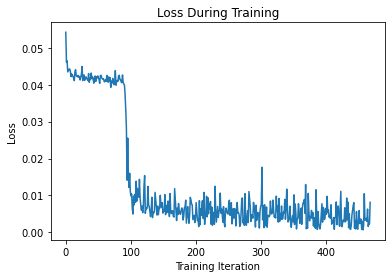

In [6]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

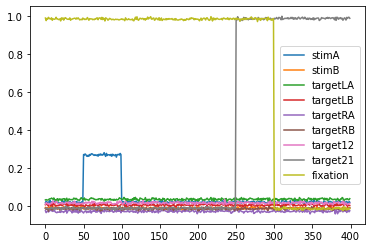

In [7]:
# ---------------------- Plot the results ---------------------------
nn=20
plt.plot(x[nn,:,:]+0.02*np.random.normal(size=(9,)))
plt.legend(['stimA','stimB','targetLA','targetLB','targetRA','targetRB','target12','target21','fixation'])
# ---------------------- Teardown the model -------------------------
# model.destruct()

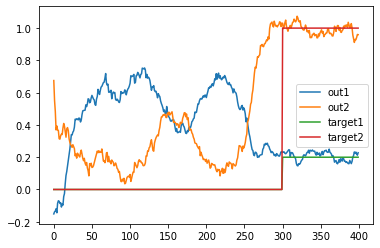

In [8]:
plt.plot(model_output[nn,:,:])
plt.plot(target_output[nn,:,:])
plt.legend(['out1','out2','target1','target2'])

/Users/jtg374/anaconda3/envs/psychrnn/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


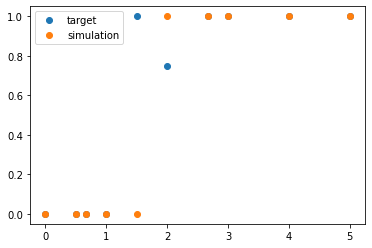

In [9]:
import numpy as np
temp = np.mean(mask * model_output,1)
choiceLR = temp[:,1]>temp[:,0]
choiceLR = choiceLR*2-1 # pos right high, neg left high

choiceFrame = [trial_params[i]['choiceFrame'] for i in range(len(trial_params))]


locAB = [(1 if trial_params[i]['locAB']=='AB' or trial_params[i]['locAB']=='12' else -1) for i in range(len(trial_params))]
loc12 = locAB
seqAB = [(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))]

choiceAB = np.array([(choiceLR[i] * locAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i] * seqAB[i]) for i in range(len(trial_params)) ])  # pos A neg B
choice12 = np.array([(choiceAB[i] * seqAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i]) for i in range(len(trial_params)) ])  # pos A neg B


qAs = np.array([trial_params[i]['qA'] for i in range(len(trial_params))])
qBs = np.array([trial_params[i]['qB'] for i in range(len(trial_params))])
offerRatio = qBs/qAs
offerRatio[offerRatio==np.Inf] = 5
ChoiceTarget =  np.array([trial_params[i]['chooseB'] for i in range(len(trial_params))])



oRs = np.unique(offerRatio)
cu = np.zeros(oRs.shape)
cc = np.zeros(oRs.shape)

for ii,oR in enumerate(oRs):
    cu[ii] = np.mean(choiceAB[offerRatio==oR])
    cc[ii] = np.mean(ChoiceTarget[offerRatio==oR])
plt.plot(oRs,cc,'o',label='target')
plt.plot(oRs,(cu+1)/2,'o',label='simulation')
plt.legend()

In [10]:
dd.a1_choice

13

In [11]:
weights = model.get_weights()
import datetime
now = datetime.datetime.now().strftime('%Y%m%d-%H-%m')
model.save('./DelayedEconomicDecision'+now)

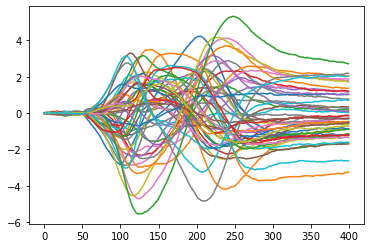

In [12]:
seqAB = [(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))]
choice12 = choiceAB*seqAB # pos first neg second
plt.plot(np.mean(model_state[choice12==1,:,:],0)-np.mean(model_state[choice12==-1,:,:],0))

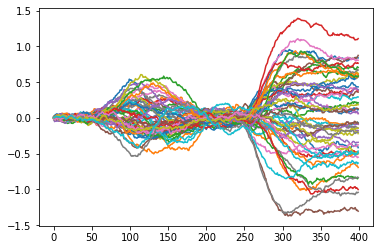

In [13]:
plt.plot(np.mean(model_state[choiceLR==1,:,:],0)-np.mean(model_state[choiceLR==-1,:,:],0))

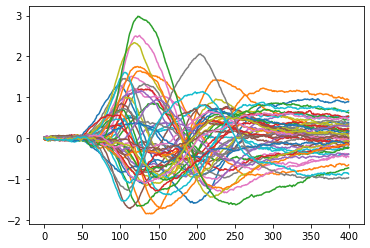

In [14]:
plt.plot(np.mean(model_state[choiceAB==1,:,:],0)-np.mean(model_state[choiceAB==-1,:,:],0))

Text(0, 0.5, 'accuracy')

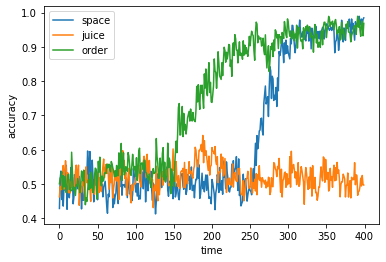

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score



nT = x.shape[1]
accuracyLR = np.zeros(nT)
accuracyAB = np.zeros(nT)
accuracy12 = np.zeros(nT)

for iT in range(nT):
    Xt = model_state[:,iT,:].squeeze()
    cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10)
    scoreLR = cross_val_score(LinearDiscriminantAnalysis(),Xt,choiceLR,scoring='accuracy',cv=cv)
    scoreAB = cross_val_score(LinearDiscriminantAnalysis(),Xt,choiceAB,scoring='accuracy',cv=cv)
    score12 = cross_val_score(LinearDiscriminantAnalysis(),Xt,choice12,scoring='accuracy',cv=cv)
    accuracyLR[iT] = np.mean(scoreLR)
    accuracyAB[iT] = np.mean(scoreAB)
    accuracy12[iT] = np.mean(score12)

plt.plot(accuracyLR)
plt.plot(accuracyAB)
plt.plot(accuracy12)
plt.legend(['space','juice','order'])
plt.xlabel('time')
plt.ylabel('accuracy')
